# BESS Optimization

This notebook demonstrates optimization techniques for Battery Energy Storage Systems (BESS) trading across multiple electricity markets.
It is a fork of Flex Power's public code for BESS Optimization, so as to explore additional directions that might be of interest.<br>
This is experimental.
<br>
This cell gives an overview of what can be found in this notebook.

#### Basic Optimization
- Sequential optimization: DAA → IDA → IDC
- Co-located PV + BESS optimization. This is done out of interest, as colocation is becoming more prevalent in many countries (e.g. Netherlands) and might become more interesting in Germany mid-2026 when legal changes to the multi-use of power storage are expected.

#### Additional Techniques
1. **Full-Stack Single MILP Optimization** 
   - Optimize all markets together in one run
   - Respects DAA hourly blocks and closing hierarchy
   - Goal: theoretical upper benchmark with perfect foresight


3. **Comprehensive Performance Metrics**
   - Computation time analysis (less relevant for the minimal example here)
   - Decomposition of market positions
   - Comparison of SOC

**Next up TODO** (not fully implemented yet):
- Rolling horizon optimization to mimic more realistic trading environment (already largely implemented in optimizer_ortools.py, but not tested yet)
- Include battery cost (e.g. cost of degradation per cycle as an input to the optimization problem)
- Stress-test profitability of battery and/or PV plant as a function of DAA/IDA/IDC prices
- Instead of co-located battery + PV, use co-located battery + PV + local power consumer; might be interesting for countries where grid fees for BESS are less advantageous than in Germany and local power consumption is more relevant
- Include physical performance of battery and inverters in terms of efficiency as a function of temperature and other weather variables
- Include grid costs and price for colocated PV bought on site.

---

**System Specs**: 2 MWh capacity, 1 MW power, 1.5 cycles/day, 1 MW grid limit

**Markets**: German Day-Ahead Auction, Intraday Auction, Intraday Continuous (ID1)

**Optimizer**: Instead of pyomo (original version), Google OR-Tools is used due to its easy integration into Python code

---



#### Import modules and optimization functions:

In [1]:
import importlib
import optimizer_ortools
importlib.reload(optimizer_ortools)  # Reload the optimizer module to pick up latest changes
from optimizer_ortools import optimizer
from matplotlib import pyplot as plt
import numpy as np
import time

#### Define some example day price profiles for the three markets and a basic solar shape:

In [2]:
daa_price_vector =  [35, 35, 35, 35, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33,
                    33, 33, 33, 33, 33, 33, 41, 41, 41, 41, 49, 49, 49, 49, 48, 48, 48, 48,
                    43, 43, 43, 43, 41, 41, 41, 41, 42, 42, 42, 42, 39, 39, 39, 39, 37, 37,
                    37, 37, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 44, 44, 44, 44,
                    48, 48, 48, 48, 53, 53, 53, 53, 51, 51, 51, 51, 48, 48, 48, 48, 47, 47,
                    47, 47, 42, 42, 42, 42]


ida_price_vector =  [38, 36, 34, 35, 34, 35, 34, 31, 35, 29, 36, 37, 30, 33, 35, 39, 31, 34,
                    36, 36, 26, 27, 36, 46, 29, 42, 50, 53, 54, 52, 48, 43, 66, 54, 43, 29,
                    55, 43, 39, 31, 51, 39, 36, 31, 48, 40, 41, 34, 48, 36, 34, 35, 40, 39,
                    35, 30, 30, 32, 36, 39, 35, 39, 36, 40, 28, 35, 41, 48, 27, 36, 49, 60,
                    32, 43, 52, 67, 44, 50, 56, 62, 53, 52, 51, 49, 53, 52, 47, 43, 56, 49,
                    44, 35, 52, 44, 39, 33]


idc_price_vector =  [36, 44, 36, 28, 29, 27, 26, 25, 31, 32, 29, 28, 25, 28, 28, 31, 28, 25,
                    34, 36, 34, 34, 38, 41, 52, 52, 52, 51, 44, 64, 48, 47, 61, 53, 48, 40,
                    48, 33, 40, 42, 47, 36, 37, 34, 45, 37, 34, 30, 31, 27, 26, 28, 30, 27,
                    22, 17, 26, 29, 24, 21, 19, 21, 21, 23, 20, 27, 32, 34, 30, 23, 27, 37,
                    26, 31, 33, 42, 25, 38, 37, 42, 43, 44, 40, 44, 43, 46, 46, 44, 48, 46,
                    41, 35, 43, 37, 31, 32]

# solar profile of 1 MWp solar farm over 96 quarter hours = 24 hours with values in MW, inverter clipping at 0.9 MW
solar_profile = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 15, 30, 55, 110, 180, 
                 260, 350, 440, 530, 610, 710, 745, 780, 810, 840, 865, 885, 900, 900, 900, 
                 900, 900, 895, 880, 865, 845, 820, 790, 755, 715, 670, 580, 480, 385, 270, 
                 220, 185, 150, 110, 80, 55, 30, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) * 0.001

#### Show example day price profiles:

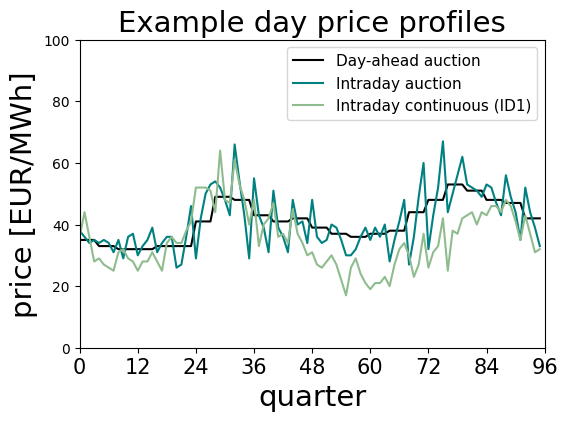

In [3]:
plt.figure(figsize=(6,4))

plt.plot(daa_price_vector,label='Day-ahead auction', color='black')
plt.plot(ida_price_vector,label='Intraday auction', color='teal')
plt.plot(idc_price_vector,label='Intraday continuous (ID1)',color='darkseagreen')

plt.title('Example day price profiles', fontsize=21)

plt.xlim(0,96)
plt.xticks([0,12,24,36,48,60,72,84,96],fontsize=15)
plt.xlabel('quarter',fontsize=21)

plt.ylim(0,100)
plt.yticks()
plt.ylabel('price [EUR/MWh]',fontsize=21)

plt.legend(fontsize=11)

## BESS ONLY

### Sequentially optimize: DA Auction, then ID Auction, then ID Continuous

In [4]:
energy_cap = 2  # MWh battery capacity
power_cap = 1   # MW battery input/output
n_cycles = 1.5  # max. mumber of cycles the battery can perform per day

Assume no PV colocation by setting all PV vector values to 0:

In [5]:
opt = optimizer()

soc1, cha1, dis1, cur1, pv_to_bess1, p1, pv_alloc1 = opt.step1_optimize_daa(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    daa_price_vector=daa_price_vector,
    pv_vector=[0]*len(daa_price_vector)  # no colocated PV
)

soc2, cha2, dis2, cha2c, dis2c, cur2, pv_to_bess2, p2, cha_tot2, dis_tot2, pv_alloc2 = opt.step2_optimize_ida(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    ida_price_vector=ida_price_vector,
    pv_vector=[0]*len(ida_price_vector),  # no colocated PV
    step1_cha_daa=cha1,
    step1_dis_daa=dis1,
    step1_pv_allocation=pv_alloc1
)

soc3, cha3, dis3, cha3c, dis3c, cur3, pv_to_bess3, p3, cha_tot3, dis_tot3 = opt.step3_optimize_idc(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    idc_price_vector=idc_price_vector,
    pv_vector=[0]*len(idc_price_vector),  # no colocated PV
    step2_cha_phys=cha_tot2,
    step2_dis_phys=dis_tot2,
    step1_pv_allocation=pv_alloc1,
    step2_pv_allocation=pv_alloc2
)

# Calculate cycles completed (1 cycle = 1 full charge + 1 full discharge)
total_charge_energy = np.sum(np.asarray(cha_tot3) * opt.DT)
total_discharge_energy = np.sum(np.asarray(dis_tot3) * opt.DT)
cycles_completed = (total_charge_energy + total_discharge_energy) / (2 * energy_cap)

# Save BESS-only profit for later comparison
bess_only_profit = p1 + p2 + p3

print("DAA profit:", round(p1, 2))
print("IDA profit:", round(p2, 2))
print("IDC profit:", round(p3, 2))
print("TOTAL BESS-ONLY:", round(bess_only_profit, 2))


print(f"Cycles completed: {cycles_completed:.2f}")

DAA profit: 53.0
IDA profit: 34.75
IDC profit: 42.25
TOTAL BESS-ONLY: 130.0
Cycles completed: 1.50


#### Calculate revenue on the three markets and total revenue:

In [6]:
revenue_daa = np.sum(np.asarray(daa_price_vector) * (np.asarray(dis1) - cha1)) * power_cap/4
revenue_ida = np.sum(np.asarray(ida_price_vector) * (np.asarray(dis2) + dis2c - cha2 - cha2c)) * power_cap/4
revenue_idc = np.sum(np.asarray(idc_price_vector) * (np.asarray(dis3) + dis3c - cha3 - cha3c)) * power_cap/4

revenue_total = revenue_daa+revenue_ida+revenue_idc
print("Total revenue calculated from price profiles and actions:", round(revenue_total,2))

Total revenue calculated from price profiles and actions: 130.0


#### Plot example day optimal schedule:

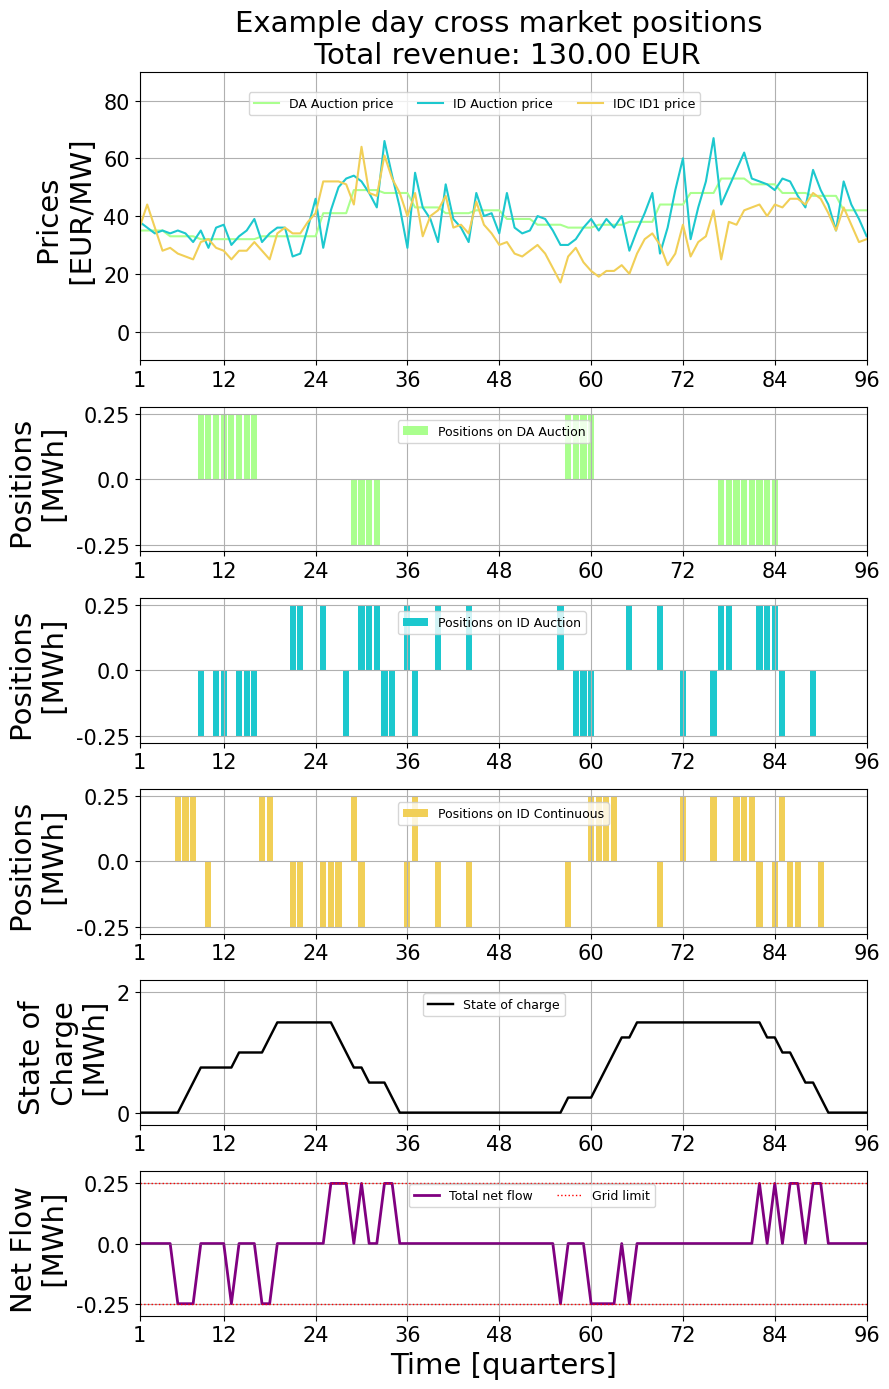

In [7]:
color1 = (170/255,1,142/255,1)
color2 = (28/255,200/255,206/255,1)
color3 = (241/255,207/255,87/255,1)

xgrid = np.arange(1, 97, 1)

fig, axs = plt.subplots(6, 1, figsize=(9, 14), gridspec_kw={'height_ratios': [2,1,1,1,1,1]})

ax1, ax2, ax3, ax4, ax5, ax6 = axs

# Subplot 1 - Prices
ax1.plot(xgrid, daa_price_vector, color=color1, label='DA Auction price')
ax1.plot(xgrid, ida_price_vector, color=color2, label='ID Auction price')
ax1.plot(xgrid, idc_price_vector, color=color3, label='IDC ID1 price')

ax1.legend(fontsize=9,ncol=4, loc=(0.15,0.85))
ax1.grid()
ax1.set_xlim(1, len(ida_price_vector))
ax1.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax1.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax1.set_yticks([0,20,40,60,80])
ax1.set_yticklabels([0,20,40,60,80], fontsize=15)
ax1.set_ylim(-10, 90)
ax1.set_ylabel('Prices \n [EUR/MW]', fontsize=21)
ax1.set_title(f'Example day cross market positions \n Total revenue: {revenue_total:.2f} EUR', fontsize=21)

# Subplot 2 - DA Auction
ax2.bar(xgrid, np.asarray(cha1)*power_cap/4, color=color1, label='Positions on DA Auction', linewidth=1.75)
ax2.bar(xgrid, np.asarray(dis1)*-power_cap/4, color=color1, linewidth=1.75)

ax2.legend(fontsize=9,ncol=4, loc=(0.355,0.75))
ax2.grid()
ax2.set_xlim(1, len(ida_price_vector))
ax2.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax2.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax2.set_ylim(-power_cap/4*1.1, power_cap/4*1.1)
ax2.set_yticks([-power_cap/4,0, power_cap/4])
ax2.set_yticklabels(ax2.get_yticks(), fontsize=15)
ax2.set_ylabel('Positions \n [MWh]', fontsize=21)

# Subplot 3 - ID Auction
ax3.bar(xgrid, np.asarray(cha2)*power_cap/4, color=color2, label='Positions on ID Auction', linewidth=1.75)
ax3.bar(xgrid, np.asarray(dis2)*-power_cap/4, color=color2, linewidth=1.75)
ax3.bar(xgrid, np.asarray(cha2c)*power_cap/4, color=color2, linewidth=1.75)
ax3.bar(xgrid, np.asarray(dis2c)*-power_cap/4, color=color2, linewidth=1.75)

ax3.legend(fontsize=9,ncol=4, loc=(0.355,0.75))
ax3.grid()
ax3.set_xlim(1, len(ida_price_vector))
ax3.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax3.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax3.set_ylim(-power_cap/4*1.1, power_cap/4*1.1)
ax3.set_yticks([-power_cap/4,0, power_cap/4])
ax3.set_yticklabels(ax2.get_yticks(), fontsize=15)
ax3.set_ylabel('Positions \n [MWh]', fontsize=21)

# Subplot 4 - ID Continuous
ax4.bar(xgrid, np.asarray(cha3)*power_cap/4, color=color3, label='Positions on ID Continuous', linewidth=1.75)
ax4.bar(xgrid, np.asarray(dis3)*-power_cap/4, color=color3, linewidth=1.75)
ax4.bar(xgrid, np.asarray(cha3c)*power_cap/4, color=color3, linewidth=1.75)
ax4.bar(xgrid, np.asarray(dis3c)*-power_cap/4, color=color3, linewidth=1.75)

ax4.legend(fontsize=9,ncol=4, loc=(0.355,0.75))
ax4.grid()
ax4.set_xlim(1, len(ida_price_vector))
ax4.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax4.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax4.set_ylim(-power_cap/4*1.1, power_cap/4*1.1)
ax4.set_yticks([-power_cap/4,0, power_cap/4])
ax4.set_yticklabels(ax2.get_yticks(), fontsize=15)
ax4.set_ylabel('Positions \n [MWh]', fontsize=21)

# Subplot 5 - State of Charge
ax5.plot(xgrid, soc3, color='black', label='State of charge', linewidth=1.75)

ax5.legend(fontsize=9,ncol=4, loc=(0.39,0.75))
ax5.grid()
ax5.set_xlim(1, len(ida_price_vector))
ax5.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax5.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax5.set_ylim(-0.2, energy_cap*1.1)
ax5.set_yticks([0, energy_cap])
ax5.set_yticklabels(ax5.get_yticks(), fontsize=15)
ax5.set_ylabel('State of \n Charge \n [MWh]', fontsize=21)

# Subplot 6 - Total Net Flow
# Calculate total net flow (BESS only, no PV)
total_net_flow = (np.asarray(dis_tot3) - np.asarray(cha_tot3)) * power_cap/4

ax6.plot(xgrid, total_net_flow, color='purple', linewidth=2, label='Total net flow')
ax6.axhline(power_cap/4, color='red', linestyle=':', linewidth=1, label='Grid limit')
ax6.axhline(-power_cap/4, color='red', linestyle=':', linewidth=1)
ax6.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

ax6.legend(fontsize=9,ncol=4, loc=(0.37,0.75))
ax6.grid()
ax6.set_xlim(1, len(ida_price_vector))
ax6.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax6.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax6.set_xlabel('Time [quarters]', fontsize=21)
ax6.set_ylim(-power_cap/4*1.2, power_cap/4*1.2)
ax6.set_yticks([-power_cap/4, 0, power_cap/4])
ax6.set_yticklabels(ax6.get_yticks(), fontsize=15)
ax6.set_ylabel('Net Flow \n [MWh]', fontsize=21)

plt.tight_layout()
plt.show()

### Single-shot MILP: DA, IDA and IDC optmized in one go

In principle, formulating the optimization model with less stringent constraints (vs. sequential optimization) should yield better results more profitable arbitrage opportunities can be found. It should also result in a theoretical upper bound of how much can be achieved across markets with perfect foresight - a benchmark that one can measure trading against. Let's try it out:

#### Test if rationale is correct

In [8]:
# Run BESS-only optimizations
print("Running BESS-only optimizations...")

# Sequential optimization (BESS only - need to run this fresh)
opt_bess = optimizer()

soc1_bess, cha1_bess, dis1_bess, cur1_bess, pv_to_bess1_bess, p1_bess, pv_alloc1_bess = opt_bess.step1_optimize_daa(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    daa_price_vector=daa_price_vector,
    pv_vector=[0]*len(daa_price_vector)  # no PV
)

soc2_bess, cha2_bess, dis2_bess, cha2c_bess, dis2c_bess, cur2_bess, pv_to_bess2_bess, p2_bess, cha_tot2_bess, dis_tot2_bess, pv_alloc2_bess = opt_bess.step2_optimize_ida(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    ida_price_vector=ida_price_vector,
    pv_vector=[0]*len(ida_price_vector),  # no PV
    step1_cha_daa=cha1_bess,
    step1_dis_daa=dis1_bess,
    step1_pv_allocation=pv_alloc1_bess
)

soc3_bess, cha3_bess, dis3_bess, cha3c_bess, dis3c_bess, cur3_bess, pv_to_bess3_bess, p3_bess, cha_tot3_bess, dis_tot3_bess = opt_bess.step3_optimize_idc(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    idc_price_vector=idc_price_vector,
    pv_vector=[0]*len(idc_price_vector),  # no PV
    step2_cha_phys=cha_tot2_bess,
    step2_dis_phys=dis_tot2_bess,
    step1_pv_allocation=pv_alloc1_bess,
    step2_pv_allocation=pv_alloc2_bess
)

sequential_profit_bess = p1_bess + p2_bess + p3_bess
print(f"Sequential BESS-only profit: {sequential_profit_bess:.2f} EUR")

# Full-stack single MILP (BESS only)
opt_full_stack_bess = optimizer()
start_time = time.time()

result_full_stack_bess = opt_full_stack_bess.optimize_full_stack_single_milp(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    daa_price_vector=daa_price_vector,
    ida_price_vector=ida_price_vector,
    idc_price_vector=idc_price_vector,
    pv_vector=[0]*len(daa_price_vector)  # no PV
)

full_stack_time_bess = time.time() - start_time

# Calculate cycles completed (1 cycle = 1 full charge + 1 full discharge)
total_charge_seq_bess = np.sum(np.asarray(cha_tot3_bess) * opt_bess.DT)
total_discharge_seq_bess = np.sum(np.asarray(dis_tot3_bess) * opt_bess.DT)
cycles_completed_seq_bess = (total_charge_seq_bess + total_discharge_seq_bess) / (2 * energy_cap)

total_charge_full_bess = np.sum(np.asarray(result_full_stack_bess['cha_phys']) * opt_full_stack_bess.DT)
total_discharge_full_bess = np.sum(np.asarray(result_full_stack_bess['dis_phys']) * opt_full_stack_bess.DT)
cycles_completed_full_bess = (total_charge_full_bess + total_discharge_full_bess) / (2 * energy_cap)

print(f"Full-stack BESS-only profit: {result_full_stack_bess['profit']:.2f} EUR")
print(f"Sequential cycles: {cycles_completed_seq_bess:.2f}, Full-stack cycles: {cycles_completed_full_bess:.2f}")

# BESS-ONLY COMPARISON (No Co-located PV)
print("\n" + "=" * 70)
print("BESS-ONLY (No PV)")
print("=" * 70)
print(f"Sequential optimization:  {sequential_profit_bess:>8.2f} EUR")
print(f"Full-stack MILP:          {result_full_stack_bess['profit']:>8.2f} EUR")
print(f"Improvement:              {(result_full_stack_bess['profit'] - sequential_profit_bess):>8.2f} EUR")
print(f"                          {((result_full_stack_bess['profit'] / sequential_profit_bess - 1) * 100):>8.2f} %")
print(f"Optimization time:        {full_stack_time_bess:>8.2f} seconds")
print("=" * 70)

Running BESS-only optimizations...
Sequential BESS-only profit: 130.00 EUR
Full-stack BESS-only profit: 221.75 EUR
Sequential cycles: 1.50, Full-stack cycles: 1.50

BESS-ONLY (No PV)
Sequential optimization:    130.00 EUR
Full-stack MILP:            221.75 EUR
Improvement:                 91.75 EUR
                             70.58 %
Optimization time:            0.22 seconds


So the thinking above was correct - now let's visualize that and compare SOCs of sequential vs. single-shot, and for completeness, let's plot the full specs as well after that:

#### Plot comparison and results

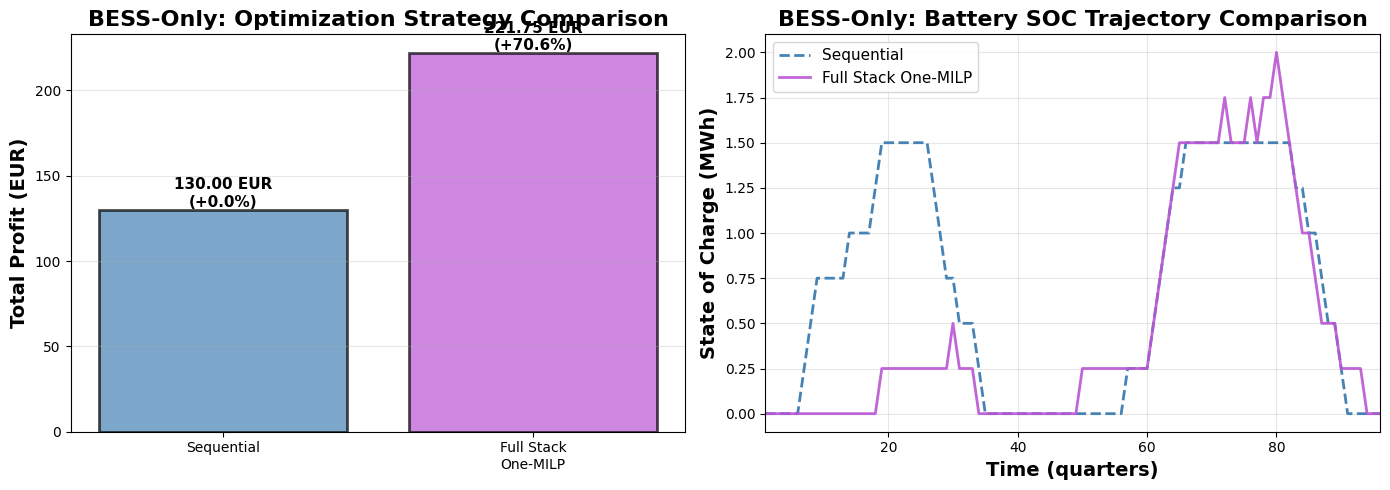

In [9]:
# Visualize BESS-only comparison (Sequential vs Full-Stack)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Profit comparison
methods = ['Sequential', 'Full Stack\nOne-MILP']
profits_bess = [sequential_profit_bess, result_full_stack_bess['profit']]
colors_bar = ['steelblue', 'mediumorchid']

bars = ax1.bar(methods, profits_bess, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Profit (EUR)', fontsize=14, fontweight='bold')
ax1.set_title('BESS-Only: Optimization Strategy Comparison', fontsize=16, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, profit in zip(bars, profits_bess):
    height = bar.get_height()
    improvement_pct = ((profit - sequential_profit_bess) / sequential_profit_bess * 100) if sequential_profit_bess > 0 else 0
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{profit:.2f} EUR\n({improvement_pct:+.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# SOC comparison over time
xgrid_bess = np.arange(1, 97)
ax2.plot(xgrid_bess, soc3_bess, label='Sequential', color='steelblue', linewidth=2, linestyle='--')
ax2.plot(xgrid_bess, result_full_stack_bess['soc'], label='Full Stack One-MILP', color='mediumorchid', linewidth=2, alpha=0.9)

ax2.set_xlabel('Time (quarters)', fontsize=14, fontweight='bold')
ax2.set_ylabel('State of Charge (MWh)', fontsize=14, fontweight='bold')
ax2.set_title('BESS-Only: Battery SOC Trajectory Comparison', fontsize=16, fontweight='bold')
ax2.legend(fontsize=11, loc='best')
ax2.grid(alpha=0.3)
ax2.set_xlim(1, 96)

plt.tight_layout()
plt.show()

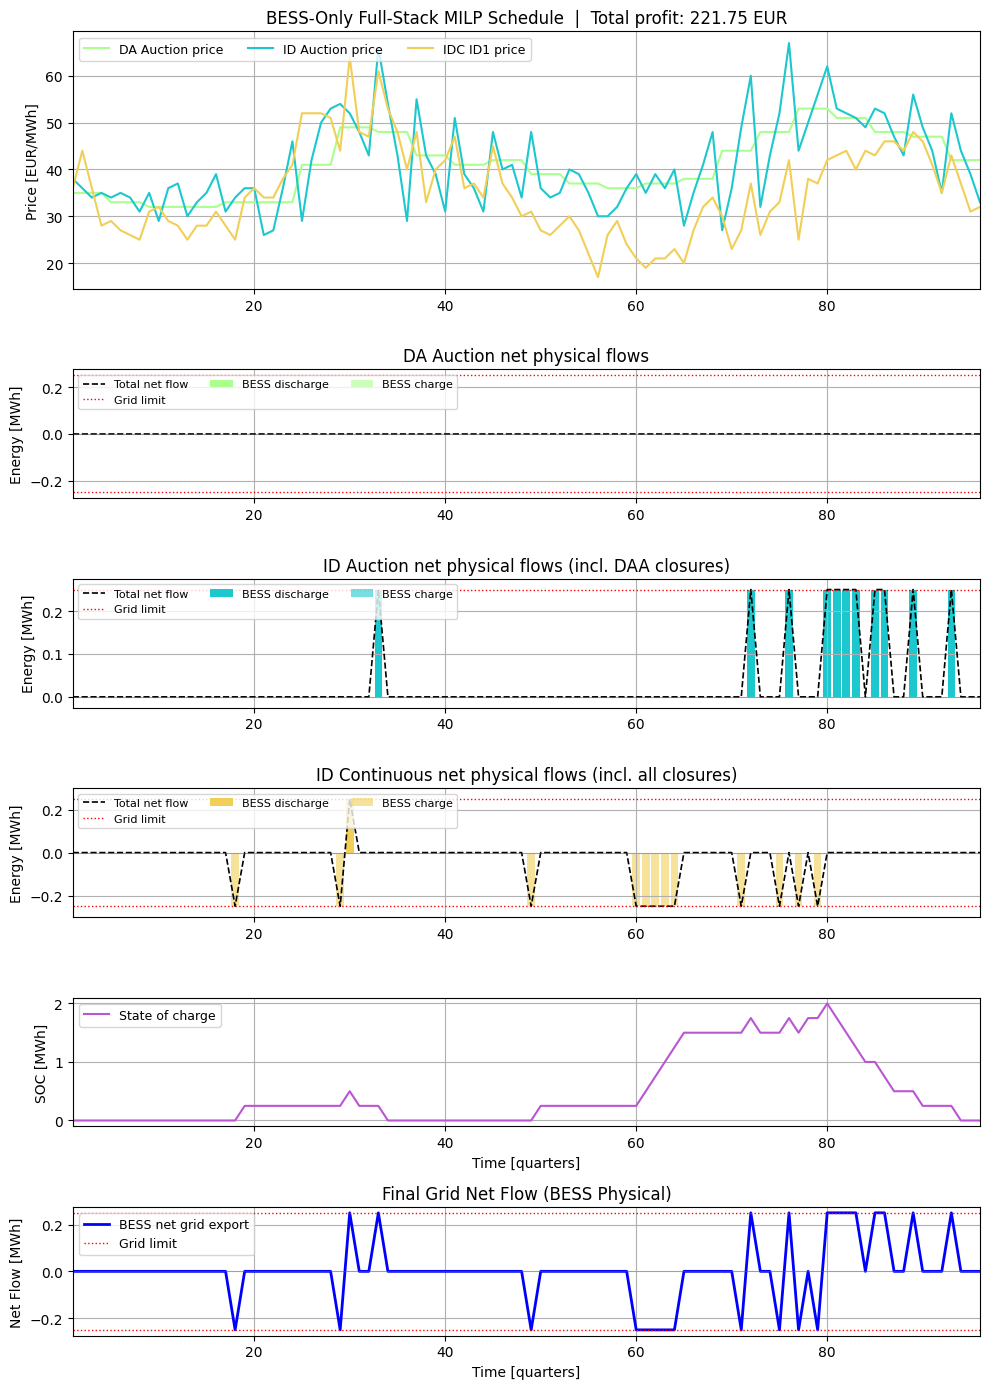

In [10]:
# Plot BESS-only Full-Stack MILP schedule - net physical flows per market
dt_bess = opt_full_stack_bess.DT
xgrid_bess = np.arange(1, 97)

# Extract full-stack BESS results
res_bess = result_full_stack_bess

# Net physical BESS positions for each market (includes closings from previous markets)
# DAA: pure DAA positions (not yet closed)
net_cha_daa_bess = np.array(res_bess['cha_daa']) - np.array(res_bess['dis_close_daa']) - np.array(res_bess['dis_close_daa_idc'])
net_dis_daa_bess = np.array(res_bess['dis_daa']) - np.array(res_bess['cha_close_daa']) - np.array(res_bess['cha_close_daa_idc'])

# IDA: new IDA positions + closings of DAA positions - IDC closings
net_cha_ida_bess = np.array(res_bess['cha_ida']) + np.array(res_bess['cha_close_daa']) - np.array(res_bess['dis_close_ida_idc'])
net_dis_ida_bess = np.array(res_bess['dis_ida']) + np.array(res_bess['dis_close_daa']) - np.array(res_bess['cha_close_ida_idc'])

# IDC: new IDC positions + closings of DAA and IDA positions
net_cha_idc_bess = np.array(res_bess['cha_idc']) + np.array(res_bess['cha_close_daa_idc']) + np.array(res_bess['cha_close_ida_idc'])
net_dis_idc_bess = np.array(res_bess['dis_idc']) + np.array(res_bess['dis_close_daa_idc']) + np.array(res_bess['dis_close_ida_idc'])

# Grid flows (net BESS physical) for each market
grid_daa_bess_full = (net_dis_daa_bess - net_cha_daa_bess) * dt_bess
grid_ida_bess_full = (net_dis_ida_bess - net_cha_ida_bess) * dt_bess
grid_idc_bess_full = (net_dis_idc_bess - net_cha_idc_bess) * dt_bess

grid_limit_bess = opt_full_stack_bess.GRID_LIMIT * dt_bess

# Calculate BESS net flow
bess_net_flow_full_only = (np.array(res_bess['dis_phys']) - np.array(res_bess['cha_phys'])) * dt_bess

fig, axs = plt.subplots(6, 1, figsize=(10, 14),
                        gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
ax_price, ax_daa, ax_ida, ax_idc, ax_soc, ax_net = axs

# Prices
ax_price.plot(xgrid_bess, daa_price_vector, color=color1, label='DA Auction price')
ax_price.plot(xgrid_bess, ida_price_vector, color=color2, label='ID Auction price')
ax_price.plot(xgrid_bess, idc_price_vector, color=color3, label='IDC ID1 price')
ax_price.legend(fontsize=9, ncol=3, loc='upper left')
ax_price.set_xlim(1, len(xgrid_bess))
ax_price.set_ylabel('Price [EUR/MWh]')
ax_price.set_title(f'BESS-Only Full-Stack MILP Schedule  |  Total profit: {round(result_full_stack_bess["profit"], 2)} EUR')
ax_price.grid()

def plot_bess_market_net_physical(ax, net_cha, net_dis, grid_net, color, title):
    cha_vals = -np.array(net_cha) * dt_bess  # Negative for charges (from grid)
    dis_vals = np.array(net_dis) * dt_bess   # Positive for discharges (to grid)
    
    ax.bar(xgrid_bess, dis_vals, color=color, label='BESS discharge')
    ax.bar(xgrid_bess, cha_vals, color=color, alpha=0.6, label='BESS charge')
    ax.plot(xgrid_bess, grid_net, color='black', linestyle='--', linewidth=1.2, label='Total net flow')
    ax.axhline(grid_limit_bess, color='red', linestyle=':', linewidth=1, label='Grid limit')
    ax.axhline(-grid_limit_bess, color='red', linestyle=':', linewidth=1)
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xlim(1, len(xgrid_bess))
    
    # Dynamic y-axis based on actual data
    all_vals = np.concatenate([cha_vals, dis_vals, grid_net])
    y_min, y_max = np.min(all_vals), np.max(all_vals)
    y_range = y_max - y_min
    if y_range > 0:
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
    
    ax.set_ylabel('Energy [MWh]')
    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=8, ncol=3, loc='upper left')
    ax.grid()

plot_bess_market_net_physical(ax_daa, net_cha_daa_bess, net_dis_daa_bess, grid_daa_bess_full, color1, 'DA Auction net physical flows')
plot_bess_market_net_physical(ax_ida, net_cha_ida_bess, net_dis_ida_bess, grid_ida_bess_full, color2, 'ID Auction net physical flows (incl. DAA closures)')
plot_bess_market_net_physical(ax_idc, net_cha_idc_bess, net_dis_idc_bess, grid_idc_bess_full, color3, 'ID Continuous net physical flows (incl. all closures)')

# State of charge
ax_soc.plot(xgrid_bess, res_bess['soc'], color='mediumorchid', linewidth=1.5, label='State of charge')
ax_soc.set_xlim(1, len(xgrid_bess))
ax_soc.set_xlabel('Time [quarters]')
ax_soc.set_ylabel('SOC [MWh]')
ax_soc.legend(fontsize=9, loc='upper left')
ax_soc.grid()

# Total net flow to grid (physical)
ax_net.plot(xgrid_bess, bess_net_flow_full_only, color='blue', linewidth=2, label='BESS net grid export')
ax_net.axhline(grid_limit_bess, color='red', linestyle=':', linewidth=1, label='Grid limit')
ax_net.axhline(-grid_limit_bess, color='red', linestyle=':', linewidth=1)
ax_net.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax_net.set_xlim(1, len(xgrid_bess))
ax_net.set_xlabel('Time [quarters]')
ax_net.set_ylabel('Net Flow [MWh]')
ax_net.set_title('Final Grid Net Flow (BESS Physical)', fontsize=12)
ax_net.legend(fontsize=9, loc='upper left')
ax_net.grid()

plt.tight_layout()
plt.show()


## Co-located BESS + PV

### Sequentially optimize: DA Auction, then ID Auction, then ID Continuous

Constraints:
- Max. 1 MW can be drawn from / injected into grid (connection constraint)<br>

Objective:
- Maximize revenue from PV + BESS over 96 quarterhours <br>

Assumptions:
- Cloudless day with near-perfect PV profile and quasi-zero profile uncertainty

Now let's see what happens: power from the PV installation is, at least with the definitions we have here, "free". In reality, it would come at a price (own investment cost or PPA with co-located PV installation owner). In this setting here, one can expect that PV will hence always be sold across markets before BESS kicks in, just because that's the way the optimization formulation will maximize the value of the objective function. At limited grid capacity, PV will hence push out BESS from the hours where it injects into the grid, forcing it into less profitable hours. Let's see:

In [11]:
# Co-located PV+BESS: Sequential optimization with PV allocation tracking
print("=" * 70)
print("CO-LOCATED PV+BESS - Sequential Optimization (DAA → IDA → IDC)")
print("=" * 70)

opt = optimizer()

# Step 1: DAA
soc1, cha1, dis1, cur1, pv_to_bess1, p1, pv_alloc1 = opt.step1_optimize_daa(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    daa_price_vector=daa_price_vector,
    pv_vector=solar_profile
)

soc2, cha2, dis2, cha2c, dis2c, cur2, pv_to_bess2, p2, cha_tot2, dis_tot2, pv_alloc2 = opt.step2_optimize_ida(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    ida_price_vector=ida_price_vector,
    pv_vector=solar_profile,
    step1_cha_daa=cha1,
    step1_dis_daa=dis1,
    step1_pv_allocation=pv_alloc1
)

soc3, cha3, dis3, cha3c, dis3c, cur3, pv_to_bess3, p3, cha_tot3, dis_tot3 = opt.step3_optimize_idc(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    idc_price_vector=idc_price_vector,
    pv_vector=solar_profile,
    step2_cha_phys=cha_tot2,
    step2_dis_phys=dis_tot2,
    step1_pv_allocation=pv_alloc1,
    step2_pv_allocation=pv_alloc2
)

colocated_profit = p1 + p2 + p3

# Calculate cycles completed
total_charge_colocated = sum(cha_tot3) * opt.DT
total_discharge_energy = sum(dis_tot3) * opt.DT
cycles_completed = (total_charge_colocated + total_discharge_energy) / (2 * energy_cap)

print("DAA profit:", round(p1, 2))
print("IDA profit:", round(p2, 2))
print("IDC profit:", round(p3, 2))
print("TOTAL CO-LOCATED:", round(colocated_profit, 2))
print(f"Cycles completed: {cycles_completed:.2f}")

# Calculate optimal PV-only revenue (sell on best market at each timestep)
rev_pv_only = 0
for t in range(len(solar_profile)):
    best_price = max(daa_price_vector[t], ida_price_vector[t], idc_price_vector[t])
    rev_pv_only += solar_profile[t] * best_price
rev_pv_only = rev_pv_only / 4  # Convert to MWh
print("\nRevenue from PV selling on best market at each timestep:", round(rev_pv_only, 2))

# Proper comparison
separate_total = bess_only_profit + rev_pv_only
print("\n" + "=" * 70)
print("COMPARISON: Co-located vs. Separate Installations")
print("=" * 70)
print(f"Co-located PV+BESS profit:      {colocated_profit:>8.2f} EUR")
print(f"Separate BESS-only profit:      {bess_only_profit:>8.2f} EUR")
print(f"Separate PV-only revenue:       {rev_pv_only:>8.2f} EUR")
print(f"Separate installations total:   {separate_total:>8.2f} EUR")
print("-" * 70)
print(f"Difference (Sep - Coloc):       {(separate_total - colocated_profit):>8.2f} EUR")
print(f"Ratio (Separate / Co-located):  {(separate_total / colocated_profit):>8.2f}")
print("=" * 70)
if separate_total > colocated_profit:
    print("Separate installations are more profitable")
    print(f"The 2 MW total grid capacity (1+1) outweighs co-located synergies")
else:
    benefit = colocated_profit - separate_total
    print(f"Co-located is MORE profitable by {benefit:.2f} EUR")

CO-LOCATED PV+BESS - Sequential Optimization (DAA → IDA → IDC)
DAA profit: 289.84
IDA profit: 37.51
IDC profit: 39.6
TOTAL CO-LOCATED: 366.95
Cycles completed: 1.50

Revenue from PV selling on best market at each timestep: 265.34

COMPARISON: Co-located vs. Separate Installations
Co-located PV+BESS profit:        366.95 EUR
Separate BESS-only profit:        130.00 EUR
Separate PV-only revenue:         265.34 EUR
Separate installations total:     395.34 EUR
----------------------------------------------------------------------
Difference (Sep - Coloc):          28.39 EUR
Ratio (Separate / Co-located):      1.08
Separate installations are more profitable
The 2 MW total grid capacity (1+1) outweighs co-located synergies


So indeed, revenue from two separate PV and BESS installations would be higher than revenue from co-located PV and BESS - at least for this particular case, notably with the constraint of max. injection of 1 MW. However, this does not take into account the fact that 
- co-location of new BESS with existing PV might lead to quicker permitting and installation vs. greenfield BESS, 
- fix grid costs (constant monthly payment, transformer costs if private transformer, etc.) is shared between PV and BESS,
both of which carry monetary value,
- this example is for a timeseries of 96 quarter hours only - over longer periods of time and at current market prices, often negative in summer, substantially different results might be achieved.

When we plot this, we see that the SOC profile changes substantially vs. the BESS-only profile for the reasons mentioned:

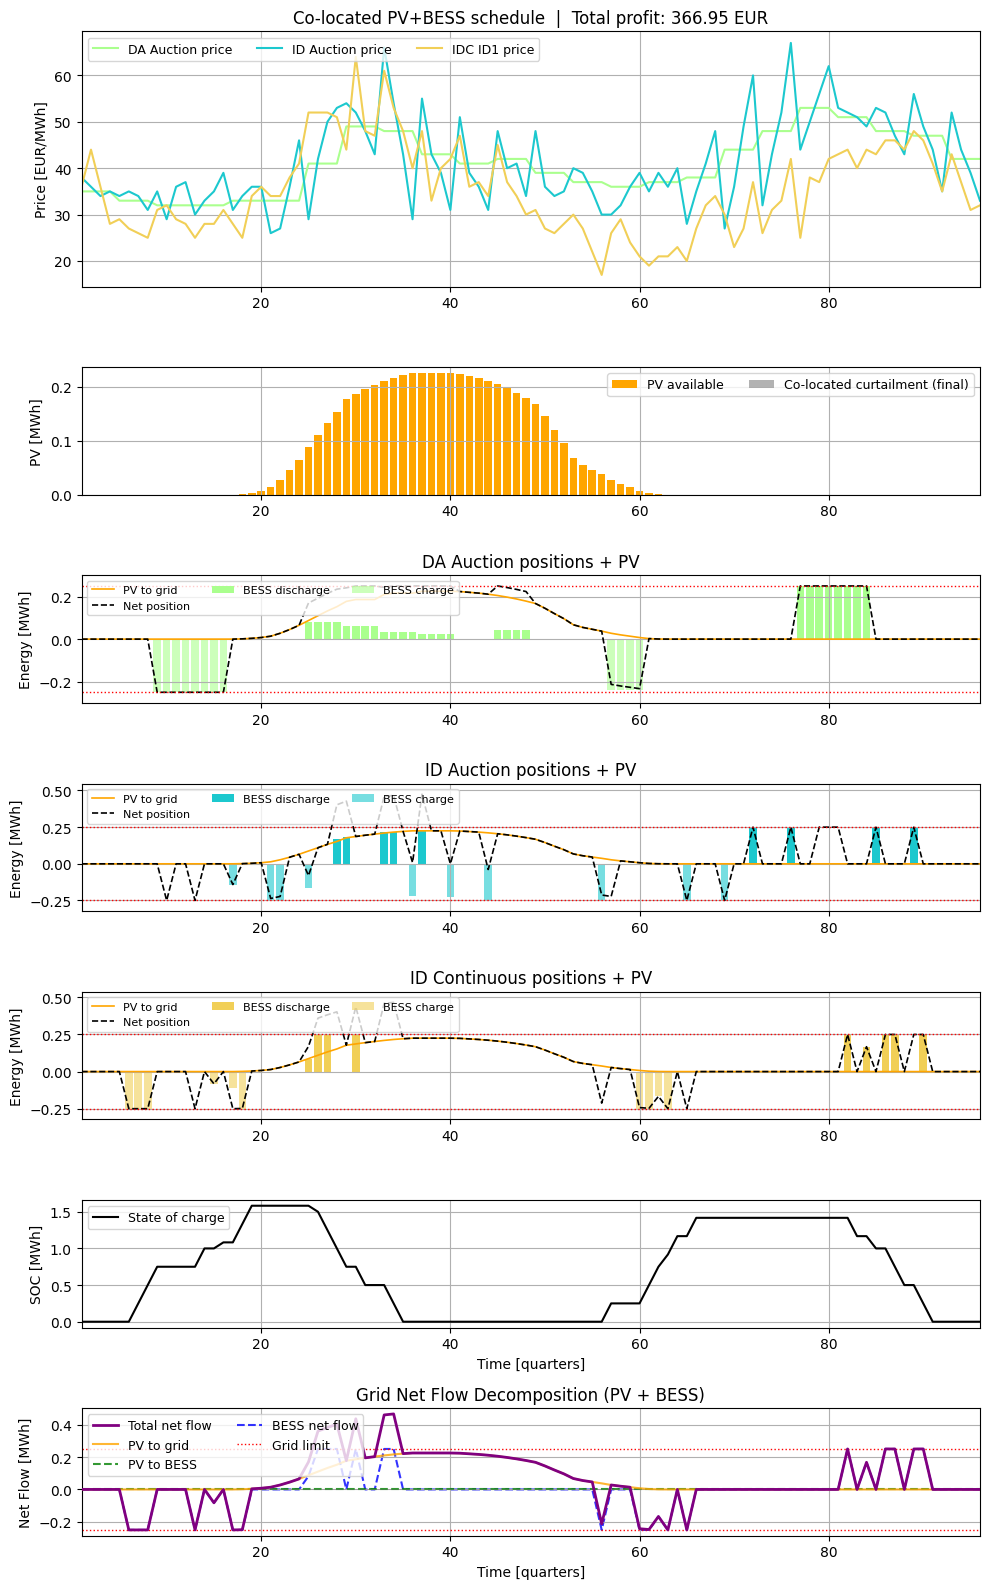

In [12]:
# Plot colocated PV + BESS schedule with PV contribution
dt = opt.DT
xgrid = np.arange(1, len(solar_profile) + 1)

pv_available = solar_profile * dt
pv_to_grid_daa = (solar_profile - np.array(cur1) - np.array(pv_to_bess1)) * dt
pv_to_grid_ida = (solar_profile - np.array(cur2) - np.array(pv_to_bess2)) * dt
pv_to_grid_idc = (solar_profile - np.array(cur3) - np.array(pv_to_bess3)) * dt

grid_daa = pv_to_grid_daa + (np.array(dis1) - np.array(cha1)) * dt
grid_ida = pv_to_grid_ida + (np.array(dis_tot2) - np.array(cha_tot2)) * dt
grid_idc = pv_to_grid_idc + (np.array(dis_tot3) - np.array(cha_tot3)) * dt
grid_limit = opt.GRID_LIMIT * dt

# Calculate components of net flow for every quarterhour
pv_to_grid = (solar_profile - np.array(cur3) - np.array(pv_to_bess3)) * dt  # PV to grid (after curtailment and battery charging)
pv_to_bess = np.array(pv_to_bess3) * dt  # PV to BESS
bess_net_flow = (np.array(dis_tot3) - np.array(cha_tot3)) * dt  # BESS discharge - charge
total_net_flow = pv_to_grid + bess_net_flow  # Total grid flow

fig, axs = plt.subplots(7, 1, figsize=(10, 16),
                        gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1]})
ax_price, ax_pv, ax_daa, ax_ida, ax_idc, ax_soc, ax_net = axs

# Prices
ax_price.plot(xgrid, daa_price_vector, color=color1, label='DA Auction price')
ax_price.plot(xgrid, ida_price_vector, color=color2, label='ID Auction price')
ax_price.plot(xgrid, idc_price_vector, color=color3, label='IDC ID1 price')
ax_price.legend(fontsize=9, ncol=3, loc='upper left')
ax_price.set_xlim(1, len(xgrid))
ax_price.set_ylabel('Price [EUR/MWh]')
ax_price.set_title(f'Co-located PV+BESS schedule  |  Total profit: {round(p1+p2+p3, 2)} EUR')
ax_price.grid()

# PV production and curtailment (per quarter, MWh)
ax_pv.bar(xgrid, pv_available, color='orange', label='PV available')
ax_pv.bar(xgrid, -np.array(cur3) * dt, color='gray', alpha=0.6, label='Co-located curtailment (final)')
ax_pv.set_xlim(1, len(xgrid))
ax_pv.set_ylabel('PV [MWh]')
ax_pv.legend(fontsize=9, ncol=2)
ax_pv.grid()

def plot_market(ax, cha, dis, pv_to_grid, grid_net, color, title):
    cha_vals = -np.array(cha) * dt  # Negative for charges (from grid)
    dis_vals = np.array(dis) * dt   # Positive for discharges (to grid)
    
    ax.bar(xgrid, dis_vals, color=color, label='BESS discharge')
    ax.bar(xgrid, cha_vals, color=color, alpha=0.6, label='BESS charge')
    ax.plot(xgrid, pv_to_grid, color='orange', linewidth=1.2, label='PV to grid')
    ax.plot(xgrid, grid_net, color='black', linestyle='--', linewidth=1.2, label='Net position')
    ax.axhline(grid_limit, color='red', linestyle=':', linewidth=1)
    ax.axhline(-grid_limit, color='red', linestyle=':', linewidth=1)
    ax.set_xlim(1, len(xgrid))
    
    # Dynamic y-axis based on actual data
    all_vals = np.concatenate([cha_vals, dis_vals, pv_to_grid, grid_net])
    y_min, y_max = np.min(all_vals), np.max(all_vals)
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
    
    ax.set_ylabel('Energy [MWh]')
    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=8, ncol=3, loc='upper left')
    ax.grid()

plot_market(ax_daa, cha1, dis1, pv_to_grid_daa, grid_daa, color1, 'DA Auction positions + PV')
plot_market(ax_ida, cha2, dis2, pv_to_grid_ida, grid_ida, color2, 'ID Auction positions + PV')
plot_market(ax_idc, cha3, dis3, pv_to_grid_idc, grid_idc, color3, 'ID Continuous positions + PV')

# State of charge
ax_soc.plot(xgrid, soc3, color='black', linewidth=1.5, label='State of charge')
ax_soc.set_xlim(1, len(xgrid))
ax_soc.set_xlabel('Time [quarters]')
ax_soc.set_ylabel('SOC [MWh]')
ax_soc.legend(fontsize=9, loc='upper left')
ax_soc.grid()

# Total net flow to grid (decomposed by PV and BESS)
ax_net.plot(xgrid, total_net_flow, color='purple', linewidth=2, label='Total net flow', zorder=4)
ax_net.plot(xgrid, pv_to_grid, color='orange', linewidth=1.5, linestyle='-', label='PV to grid', alpha=0.8, zorder=3)
ax_net.plot(xgrid, -pv_to_bess, color='green', linewidth=1.5, linestyle='--', label='PV to BESS', alpha=0.8, zorder=2)
ax_net.plot(xgrid, bess_net_flow, color='blue', linewidth=1.5, linestyle='--', label='BESS net flow', alpha=0.8, zorder=1)
ax_net.axhline(grid_limit, color='red', linestyle=':', linewidth=1, label='Grid limit')
ax_net.axhline(-grid_limit, color='red', linestyle=':', linewidth=1)
ax_net.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax_net.set_xlim(1, len(xgrid))
ax_net.set_xlabel('Time [quarters]')
ax_net.set_ylabel('Net Flow [MWh]')
ax_net.set_title('Grid Net Flow Decomposition (PV + BESS)', fontsize=12)
ax_net.legend(fontsize=9, loc='upper left', ncol=2)
ax_net.grid()

plt.tight_layout()
plt.show()

### Single-shot MILP: DA, IDA and IDC optimized in one go
In this approach, we optimize all three markets in one MILP optimization, all while respecting:
- DAA hourly block constraints (DAA was traded hourly at the time this notebook was originally created)
- Natural market closing cascade (IDA can close DAA; IDC can close both)
- Physical battery and grid constraints

Same as above, this represents a theoretical upper bound compared to sequential optimization, as it respects market structure while optimizing jointly across all available markets.

In [13]:
# Full-stack single MILP
import time
opt_full_stack = optimizer()
start_time = time.time()

result_full_stack = opt_full_stack.optimize_full_stack_single_milp(
    n_cycles=n_cycles,
    energy_cap=energy_cap,
    power_cap=power_cap,
    daa_price_vector=daa_price_vector,
    ida_price_vector=ida_price_vector,
    idc_price_vector=idc_price_vector,
    pv_vector=solar_profile
)

full_stack_time = time.time() - start_time

# Calculate cycles completed (1 cycle = 1 full charge + 1 full discharge)
total_charge_energy_full = np.sum(np.asarray(result_full_stack['cha_phys']) * opt_full_stack.DT)
total_discharge_energy_full = np.sum(np.asarray(result_full_stack['dis_phys']) * opt_full_stack.DT)
cycles_completed_full = (total_charge_energy_full + total_discharge_energy_full) / (2 * energy_cap)

profit_full = result_full_stack['profit_by_market']
print("=" * 60)
print("FULL-STACK ONE-SHOT MILP (DAA/IDA/IDC layered)")
print("=" * 60)
print(f"Total Profit:    {result_full_stack['profit']:.2f} EUR")
print()
print("Profit by Market:")
print(f"  DAA:           {profit_full['daa']:.2f} EUR")
print(f"  IDA:           {profit_full['ida']:.2f} EUR")
print(f"  IDC:           {profit_full['idc']:.2f} EUR")
print(f"Cycles completed: {cycles_completed_full:.2f}")
print(f"Optimization Time: {full_stack_time:.2f} seconds")

print("=" * 60)

FULL-STACK ONE-SHOT MILP (DAA/IDA/IDC layered)
Total Profit:    482.81 EUR

Profit by Market:
  DAA:           192.69 EUR
  IDA:           335.92 EUR
  IDC:           -45.80 EUR
Cycles completed: 1.50
Optimization Time: 0.89 seconds


For the same reasons above as for BESS alone, the results are better if the model is free to optimize across markets. This is the theoretical upper bound of profit that one can achieve across market with our co-located BESS + PV. Let's quantify and plot:


OPTIMIZATION STRATEGY COMPARISON
Method                         Profit (EUR)    vs Sequential       
----------------------------------------------------------------------
Sequential (Original)          366.95          Baseline            
Full Stack (One-MILP)          482.81          +31.57%


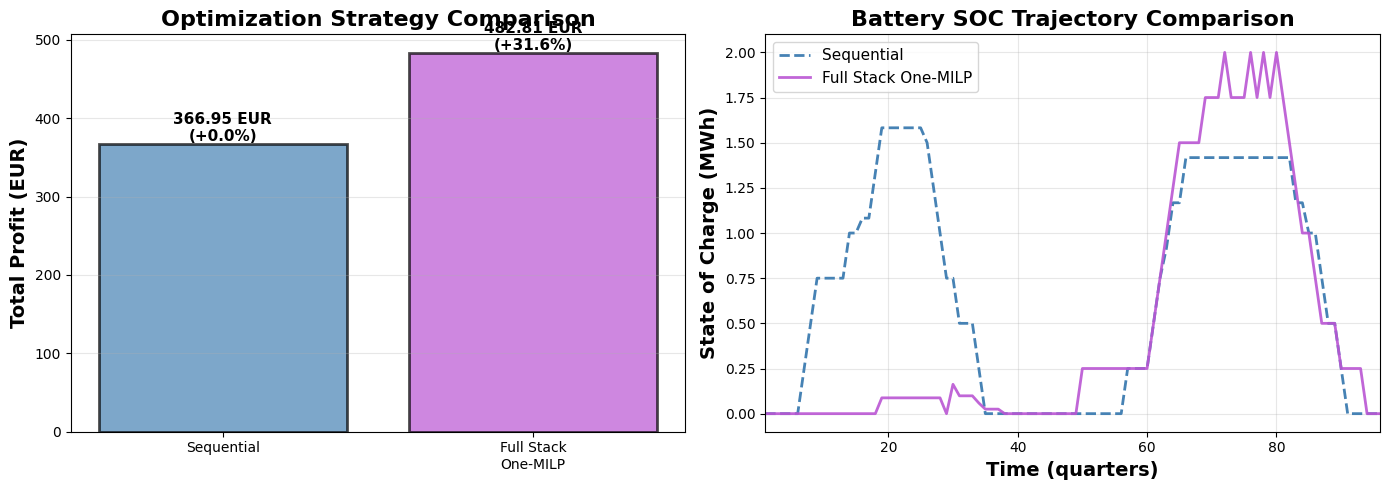

In [14]:
# Calculate sequential profit (from earlier cells)
sequential_profit = p1 + p2 + p3

# Calculate improvement percentage
base_profit = sequential_profit
full_stack_improvement = (result_full_stack['profit'] - base_profit) / base_profit * 100

print("\n" + "=" * 70)
print("OPTIMIZATION STRATEGY COMPARISON")
print("=" * 70)
print(f"{'Method':<30} {'Profit (EUR)':<15} {'vs Sequential':<20}")
print("-" * 70)
print(f"{'Sequential (Original)':<30} {sequential_profit:<15.2f} {'Baseline':<20}")
print(f"{'Full Stack (One-MILP)':<30} {result_full_stack['profit']:<15.2f} {full_stack_improvement:+.2f}%")
print("=" * 70)

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Profit comparison
methods = ['Sequential', 'Full Stack\nOne-MILP']
profits = [sequential_profit, result_full_stack['profit']]
colors_bar = ['steelblue', 'mediumorchid']

bars = ax1.bar(methods, profits, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Profit (EUR)', fontsize=14, fontweight='bold')
ax1.set_title('Optimization Strategy Comparison', fontsize=16, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, profit in zip(bars, profits):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{profit:.2f} EUR\n({((profit-sequential_profit)/sequential_profit*100):+.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# SOC comparison over time
xgrid = np.arange(1, 97)
ax2.plot(xgrid, soc3, label='Sequential', color='steelblue', linewidth=2, linestyle='--')
ax2.plot(xgrid, result_full_stack['soc'], label='Full Stack One-MILP', color='mediumorchid', linewidth=2, alpha=0.9)

ax2.set_xlabel('Time (quarters)', fontsize=14, fontweight='bold')
ax2.set_ylabel('State of Charge (MWh)', fontsize=14, fontweight='bold')
ax2.set_title('Battery SOC Trajectory Comparison', fontsize=16, fontweight='bold')
ax2.legend(fontsize=11, loc='best')
ax2.grid(alpha=0.3)
ax2.set_xlim(1, 96)

plt.tight_layout()
plt.show()

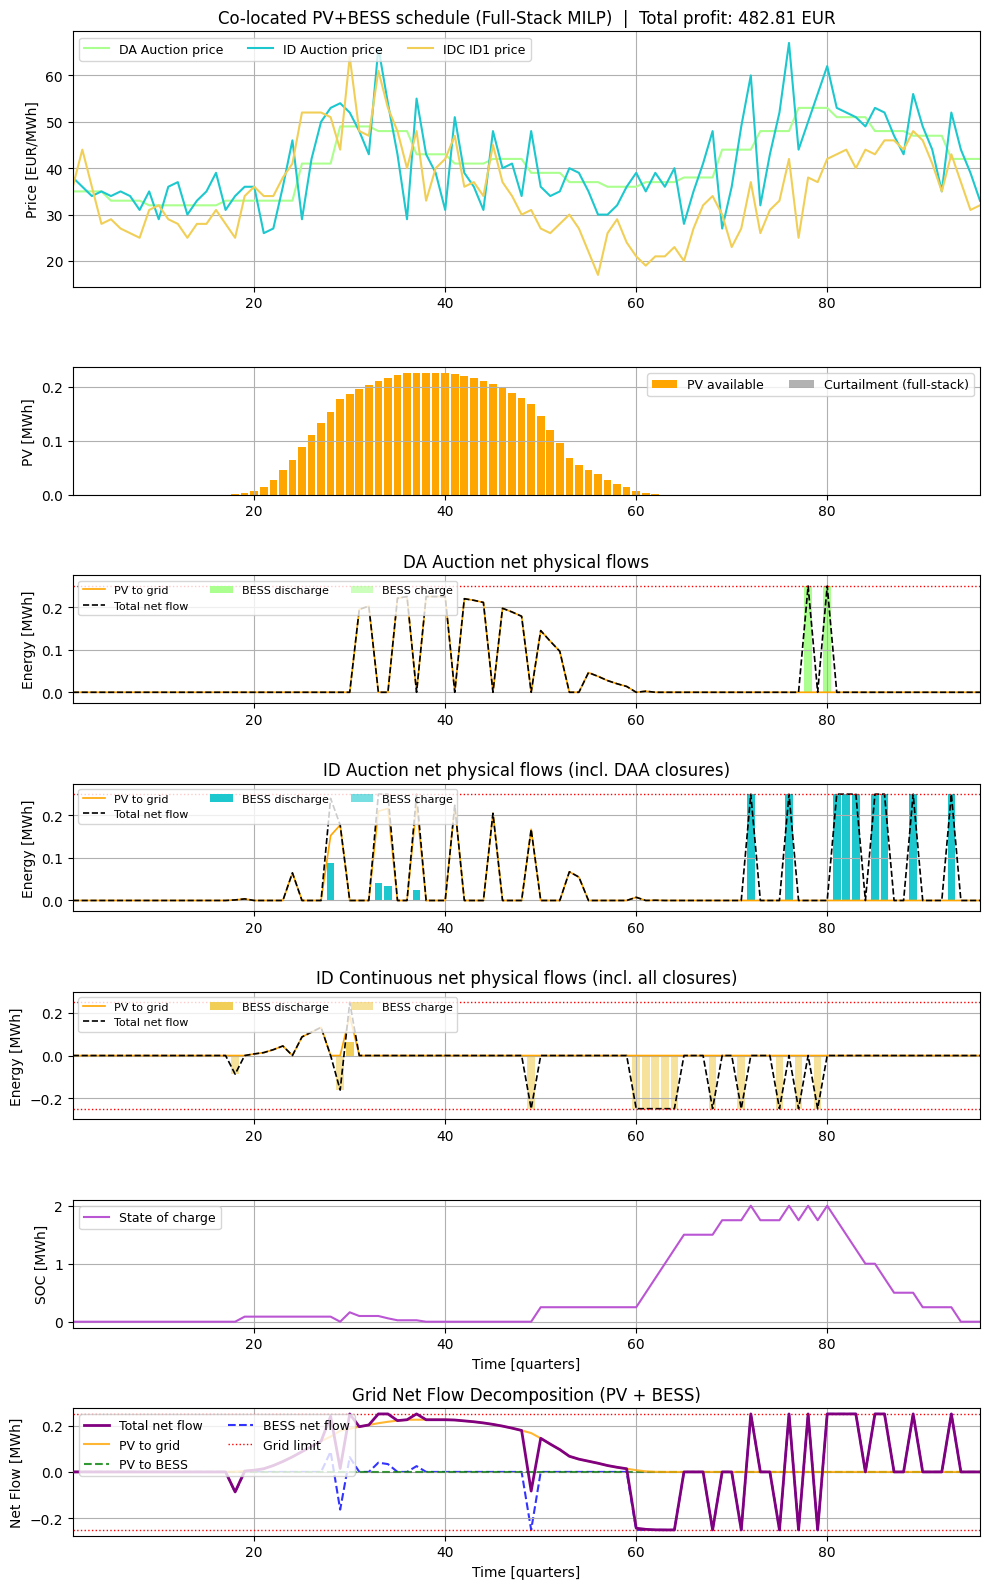

In [15]:
# Plot colocated PV + BESS schedule with PV contribution - FULL-STACK MILP
dt = opt_full_stack.DT
xgrid = np.arange(1, len(solar_profile) + 1)

# Extract full-stack results
res = result_full_stack

# PV flows
pv_available = solar_profile * dt
pv_curtailed = np.array(res['curtail']) * dt

# Physical flows per market
pv_to_grid_daa_full = np.array(res['pv_to_daa']) * dt
pv_to_grid_ida_full = np.array(res['pv_to_ida']) * dt
pv_to_grid_idc_full = np.array(res['pv_to_idc']) * dt

# Net physical BESS positions for each market (includes closings from previous markets)
# DAA: pure DAA positions (not yet closed)
net_cha_daa = np.array(res['cha_daa']) - np.array(res['dis_close_daa']) - np.array(res['dis_close_daa_idc'])
net_dis_daa = np.array(res['dis_daa']) - np.array(res['cha_close_daa']) - np.array(res['cha_close_daa_idc'])

# IDA: new IDA positions + closings of DAA positions - IDC closings
net_cha_ida = np.array(res['cha_ida']) + np.array(res['cha_close_daa']) - np.array(res['dis_close_ida_idc'])
net_dis_ida = np.array(res['dis_ida']) + np.array(res['dis_close_daa']) - np.array(res['cha_close_ida_idc'])

# IDC: new IDC positions + closings of DAA and IDA positions
net_cha_idc = np.array(res['cha_idc']) + np.array(res['cha_close_daa_idc']) + np.array(res['cha_close_ida_idc'])
net_dis_idc = np.array(res['dis_idc']) + np.array(res['dis_close_daa_idc']) + np.array(res['dis_close_ida_idc'])

# Grid flows (PV + net BESS) for each market
grid_daa_full = pv_to_grid_daa_full + (net_dis_daa - net_cha_daa) * dt
grid_ida_full = pv_to_grid_ida_full + (net_dis_ida - net_cha_ida) * dt
grid_idc_full = pv_to_grid_idc_full + (net_dis_idc - net_cha_idc) * dt

grid_limit = opt_full_stack.GRID_LIMIT * dt

# Calculate components of net flow for every quarterhour (final = all markets)
pv_to_grid_full = (np.array(res['pv_to_daa']) + np.array(res['pv_to_ida']) + np.array(res['pv_to_idc'])) * dt  # PV to grid
pv_to_bess_full = np.array(res['pv_to_bess']) * dt  # PV to BESS
bess_net_flow_full = (np.array(res['dis_phys']) - np.array(res['cha_phys'])) * dt  # BESS discharge - charge
total_net_flow_full = pv_to_grid_full + bess_net_flow_full  # Total grid flow

fig, axs = plt.subplots(7, 1, figsize=(10, 16),
                        gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1]})
ax_price, ax_pv, ax_daa, ax_ida, ax_idc, ax_soc, ax_net = axs

# Prices
ax_price.plot(xgrid, daa_price_vector, color=color1, label='DA Auction price')
ax_price.plot(xgrid, ida_price_vector, color=color2, label='ID Auction price')
ax_price.plot(xgrid, idc_price_vector, color=color3, label='IDC ID1 price')
ax_price.legend(fontsize=9, ncol=3, loc='upper left')
ax_price.set_xlim(1, len(xgrid))
ax_price.set_ylabel('Price [EUR/MWh]')
ax_price.set_title(f'Co-located PV+BESS schedule (Full-Stack MILP)  |  Total profit: {round(result_full_stack["profit"], 2)} EUR')
ax_price.grid()

# PV production and curtailment (per quarter, MWh)
ax_pv.bar(xgrid, pv_available, color='orange', label='PV available')
ax_pv.bar(xgrid, -pv_curtailed, color='gray', alpha=0.6, label='Curtailment (full-stack)')
ax_pv.set_xlim(1, len(xgrid))
ax_pv.set_ylabel('PV [MWh]')
ax_pv.legend(fontsize=9, ncol=2)
ax_pv.grid()

def plot_market_net_physical(ax, net_cha, net_dis, pv_to_grid, grid_net, color, title):
    cha_vals = -np.array(net_cha) * dt  # Negative for charges (from grid)
    dis_vals = np.array(net_dis) * dt   # Positive for discharges (to grid)
    
    ax.bar(xgrid, dis_vals, color=color, label='BESS discharge')
    ax.bar(xgrid, cha_vals, color=color, alpha=0.6, label='BESS charge')
    ax.plot(xgrid, pv_to_grid, color='orange', linewidth=1.2, label='PV to grid')
    ax.plot(xgrid, grid_net, color='black', linestyle='--', linewidth=1.2, label='Total net flow')
    ax.axhline(grid_limit, color='red', linestyle=':', linewidth=1)
    ax.axhline(-grid_limit, color='red', linestyle=':', linewidth=1)
    ax.set_xlim(1, len(xgrid))
    
    # Dynamic y-axis based on actual data
    all_vals = np.concatenate([cha_vals, dis_vals, pv_to_grid, grid_net])
    y_min, y_max = np.min(all_vals), np.max(all_vals)
    y_range = y_max - y_min
    if y_range > 0:
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
    
    ax.set_ylabel('Energy [MWh]')
    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=8, ncol=3, loc='upper left')
    ax.grid()

plot_market_net_physical(ax_daa, net_cha_daa, net_dis_daa, pv_to_grid_daa_full, grid_daa_full, color1, 'DA Auction net physical flows')
plot_market_net_physical(ax_ida, net_cha_ida, net_dis_ida, pv_to_grid_ida_full, grid_ida_full, color2, 'ID Auction net physical flows (incl. DAA closures)')
plot_market_net_physical(ax_idc, net_cha_idc, net_dis_idc, pv_to_grid_idc_full, grid_idc_full, color3, 'ID Continuous net physical flows (incl. all closures)')

# State of charge
ax_soc.plot(xgrid, res['soc'], color='mediumorchid', linewidth=1.5, label='State of charge')
ax_soc.set_xlim(1, len(xgrid))
ax_soc.set_xlabel('Time [quarters]')
ax_soc.set_ylabel('SOC [MWh]')
ax_soc.legend(fontsize=9, loc='upper left')
ax_soc.grid()

# Total net flow to grid (decomposed by PV and BESS)
ax_net.plot(xgrid, total_net_flow_full, color='purple', linewidth=2, label='Total net flow', zorder=4)
ax_net.plot(xgrid, pv_to_grid_full, color='orange', linewidth=1.5, linestyle='-', label='PV to grid', alpha=0.8, zorder=3)
ax_net.plot(xgrid, -pv_to_bess_full, color='green', linewidth=1.5, linestyle='--', label='PV to BESS', alpha=0.8, zorder=2)
ax_net.plot(xgrid, bess_net_flow_full, color='blue', linewidth=1.5, linestyle='--', label='BESS net flow', alpha=0.8, zorder=1)
ax_net.axhline(grid_limit, color='red', linestyle=':', linewidth=1, label='Grid limit')
ax_net.axhline(-grid_limit, color='red', linestyle=':', linewidth=1)
ax_net.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax_net.set_xlim(1, len(xgrid))
ax_net.set_xlabel('Time [quarters]')
ax_net.set_ylabel('Net Flow [MWh]')
ax_net.set_title('Grid Net Flow Decomposition (PV + BESS)', fontsize=12)
ax_net.legend(fontsize=9, loc='upper left', ncol=2)
ax_net.grid()

plt.tight_layout()
plt.show()
